# Financial derivatives proposal 

Rodrigo Hernández Mota | Daniela Guerra Alcalá | Yolanda Rodriguez Cañedo 

In [3]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from financial_series.everything import *

## Download Asset Prices 

For this example the asset in consideration is the foreign exchange rate **USDMXN**.

In [4]:
_from = dt.datetime.strftime(dt.datetime.now() - dt.timedelta(days=360),'%Y/%m/%d')
_now  = dt.datetime.strftime(dt.datetime.now(),'%Y/%m/%d')

asset = Currency(units='MXN', base = 'USD', t0 = _from, tf = _now)
asset.fill()

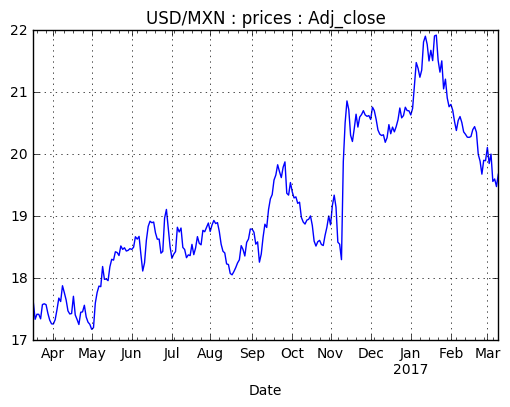

In [5]:
asset.plot()
plt.grid()

The kernel density estimation of the returns (regarding all recorded data) can be obtained with pandas library. The visualization of the kde is the following: 

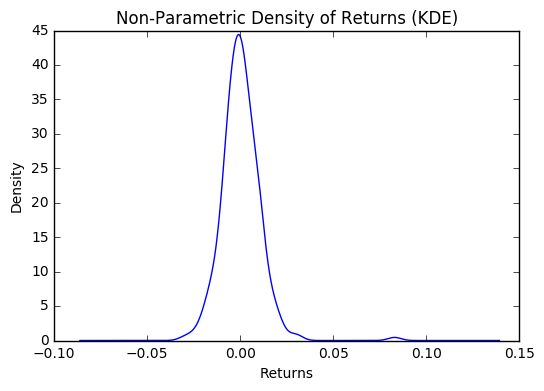

In [7]:

# Plot kernel density estimator  
random_variable = asset.returns.Adj_close.plot(kind='kde')
plt.title('Non-Parametric Density of Returns (KDE)')
plt.xlabel('Returns')


# Get returns and density from plot
x_val, y_val    = random_variable.get_children()[0]._x, random_variable.get_children()[0]._y

# Save into dataframe 
random_variable = pd.DataFrame({'x':x_val,'density':y_val})

Given the KDE we proceed to calculate the cummulative distribution (CDE) of the returns. 

In [8]:

# Calculate the cummulative distribution 
acum = 0
acum_vect = []
for d in random_variable.density:
    acum += d
    acum_vect.append(acum)

# Save into dataframe 
random_variable['cumulative'] = np.array(acum_vect)/acum


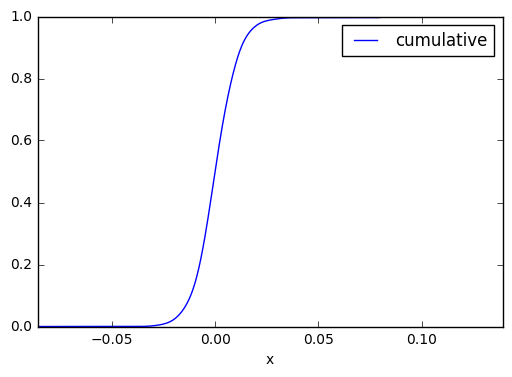

In [10]:

# Plot the cummulative distribution  
random_variable.plot(x='x',y='cumulative')


With this cummulative distribution we can generate random numbers that distributes as the kde. 

In [12]:


def getRandomValue(reference):
    unif = np.random.uniform()
    index = sum(reference.cumulative < unif)
    return reference.x.iloc[index]

def getRandomVect(n,reference):
    return np.array([getRandomValue(reference) for i in range(n)])

Example:

In [13]:
getRandomValue(random_variable)

-0.0051504966850579315

# Trajectories according to the KDE

Initial value (S0) is the last price recorded. 

In [18]:
S0 = asset.prices.Adj_close.iloc[-1]

Now we code some functions to generate "m" trajectories (simulations). 

In [19]:
def mTrajectoriesKde(S0=100,T=1,n=360,m=1):
    rnd = list(map(lambda x: getRandomVect(n,random_variable),range(m)))
    log_increment = [np.concatenate([np.array([np.log(S0)]),i]) for i in rnd]
    log_path      = [np.cumsum(i) for i in log_increment]
    return pd.DataFrame(np.asmatrix([np.exp(i) for i in log_path]).T)

def mTrajectoriesNormal(S0=100,mu=0,sigma=0.2,T=1,n=360,m=1):
    dt = T/n
    mu_t, sigma_t = (mu-sigma**2/2)*dt, sigma*np.sqrt(dt)
    rnd = list(map(lambda x: np.random.normal(mu_t,sigma_t,n),range(m)))
    log_increment = [np.concatenate([np.array([np.log(S0)]),i]) for i in rnd]
    log_path      = [np.cumsum(i) for i in log_increment]
    return pd.DataFrame(np.asmatrix([np.exp(i) for i in log_path]).T)

Calculate trajectories.

In [23]:

# Calculate the simulation
#simul_normal = mTrajectoriesNormal(S0=S0,m=50,mu=asset.returns.Adj_close.mean(),sigma=asset.returns.Adj_close.std())
m_trajectories = 100
simul_kde    = mTrajectoriesKde(S0=S0,m=m_trajectories)

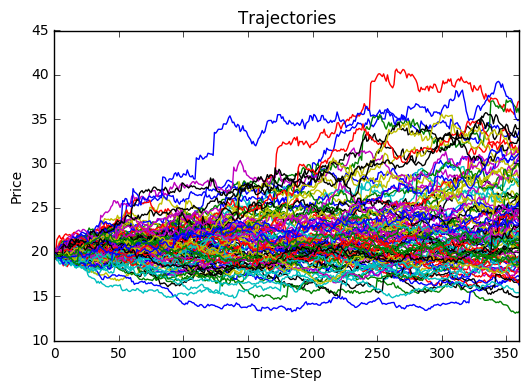

In [24]:
#simul_normal.plot(legend=False)
simul_kde.plot(legend=False)
plt.title('Trajectories')
plt.xlabel('Time-Step')
plt.ylabel('Price')

## Derivative Proposal 

The derivative proposed is rather simple. In essence, its a vanilla option with the opportunity to execute at maturity but subject to a possible forced activation if a condition is reached before. 

The condition that generated a forced execution before the maturity is whenever the subyacent asset cross a boundry known as "the beta curve". 

This curve is calculated by simulating "n" possible trajectories using montecarlo with random numbers generated according to the empirical estimated distribution (by kernel density) and determining the value $\beta_t$ for each time-step $t \in [0,1,2,...,n]$ in a given time-interval such that $P(S_t < \beta_t) \approx \alpha$ for put-options and $P(S_t > \beta_t) \approx \alpha$ for call-options. Where $\alpha$ is an arbitrary probability. 


In [44]:

# Get beta for a given t 
def getBeta(alpha,vect,tol=100000):
    not_found = True 
    vect  = np.array(vect)
    value = 0
    n = len(vect)
    while(not_found):
        probability = sum(vect < value) / n
        if probability < alpha:
            value += 0.1
            tol -= 1
        else: 
            not_found=False 
        if not tol:
            print('Error: tolerance limit reached')
            return None
            
    return value


Beta curve with strike price and simulated trajectories. 

In [45]:
df = simul_kde
alpha = 0.10
beta_line = df.apply(lambda x: getBeta(alpha=alpha,vect=x),1)

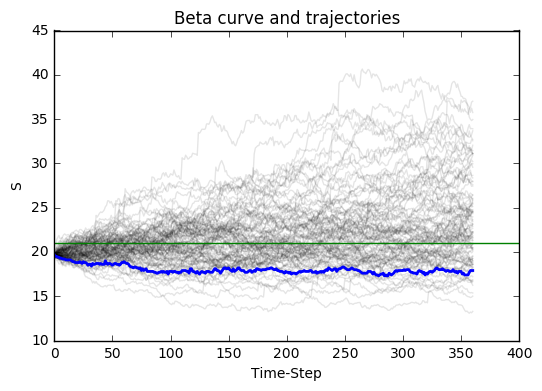

In [52]:

k = 21
for cols in df:
    plt.plot(df[cols],'black',alpha=0.1)
plt.plot(beta_line.values,'b',linewidth=2)
plt.axhline(y=k,xmin=0,xmax=len(df),color='green',linewidth=1)
plt.title('Beta curve and trajectories')
plt.xlabel('Time-Step')
plt.ylabel('S')
plt.show()

Invalid trajectories. 

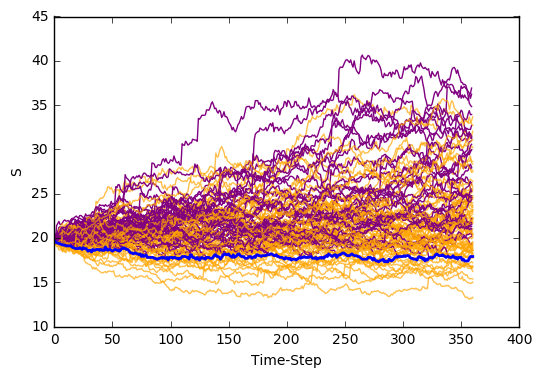

In [71]:
probability_in_t = {}
for t in df:
    ref = 0
    cond = True
    while(cond):
        ref += 1
        if df[t].iloc[ref]<beta_line.iloc[ref]:
            cond = False
        if ref == len(df)-1:
            break
            
    # save pobability 
    if ref not in probability_in_t.keys():
        probability_in_t[ref] = 1
    else:
        probability_in_t[ref] += 1
        
    # plot 
    plt.plot(df[t].iloc[:ref].index.values,df[t].iloc[:ref].values,'purple',alpha=1)
    plt.plot(df[t].iloc[ref:].index.values,df[t].iloc[ref:].values,'orange',alpha=0.7)
    
plt.plot(beta_line.values,'blue',linewidth=2)
plt.title('')
plt.ylabel('S')
plt.xlabel('Time-Step')
plt.show()
    

In [73]:
probability_in_t

{1: 15,
 2: 12,
 3: 7,
 4: 1,
 5: 3,
 6: 1,
 7: 1,
 8: 2,
 9: 1,
 15: 1,
 16: 1,
 17: 1,
 24: 1,
 25: 1,
 44: 1,
 49: 1,
 58: 1,
 60: 1,
 64: 1,
 80: 1,
 127: 1,
 131: 1,
 149: 1,
 168: 1,
 184: 1,
 185: 1,
 223: 1,
 243: 1,
 276: 1,
 299: 1,
 323: 1,
 341: 1,
 360: 34}

In [68]:
keys = list(probability_in_t.keys())
keys.sort()

survivors = m_trajectories

for k in keys:
    dead = probability_in_t[k]
    probability_in_t[k] = dead / survivors
    survivors = survivors - dead

In [69]:
probability_in_t

{1: 0.15,
 2: 0.1411764705882353,
 3: 0.0958904109589041,
 4: 0.015151515151515152,
 5: 0.046153846153846156,
 6: 0.016129032258064516,
 7: 0.01639344262295082,
 8: 0.03333333333333333,
 9: 0.017241379310344827,
 15: 0.017543859649122806,
 16: 0.017857142857142856,
 17: 0.01818181818181818,
 24: 0.018518518518518517,
 25: 0.018867924528301886,
 44: 0.019230769230769232,
 49: 0.0196078431372549,
 58: 0.02,
 60: 0.02040816326530612,
 64: 0.020833333333333332,
 80: 0.02127659574468085,
 127: 0.021739130434782608,
 131: 0.022222222222222223,
 149: 0.022727272727272728,
 168: 0.023255813953488372,
 184: 0.023809523809523808,
 185: 0.024390243902439025,
 223: 0.025,
 243: 0.02564102564102564,
 276: 0.02631578947368421,
 299: 0.02702702702702703,
 323: 0.027777777777777776,
 341: 0.02857142857142857,
 360: 1.0}